# Decision Trees & Boosting

In [31]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
from sklearn import discriminant_analysis
from sklearn import model_selection
from sklearn import tree as Tree
from sklearn import ensemble
import sklearn.tree
%matplotlib inline 

### Load in data

In [75]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/master_8020_df.csv',index_col=0)

In [33]:
data.head(5)

,Previous_10_Left_Choice,Previous_10_Right_Choice,Previous_10_Left_Reward,Previous_10_Right_Reward,Streak,5_Port,5_Reward,5_ITI,5_trialDuration,4_Port,...,2_Reward,2_ITI,2_trialDuration,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,0_trialDuration,Decision
0,10.0,0.0,10.0,0.0,0.0,1.0,1.0,2.023,0.339,1.0,...,1.0,1.670,0.308,1.0,1.0,2.240,0.304,2.452,0.355,1.0
1,10.0,0.0,10.0,0.0,0.0,1.0,1.0,2.405,0.342,1.0,...,1.0,2.240,0.304,1.0,1.0,2.452,0.355,2.225,0.334,1.0
2,10.0,0.0,10.0,0.0,0.0,1.0,1.0,6.294,0.450,1.0,...,1.0,2.452,0.355,1.0,1.0,2.225,0.334,2.323,0.301,1.0
3,10.0,0.0,10.0,0.0,0.0,1.0,1.0,1.670,0.308,1.0,...,1.0,2.225,0.334,1.0,1.0,2.323,0.301,2.255,0.429,1.0
4,10.0,0.0,10.0,0.0,0.0,1.0,1.0,2.240,0.304,1.0,...,1.0,2.323,0.301,1.0,1.0,2.255,0.429,2.124,0.309,1.0


In [76]:
#extract features and decisions
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

### Change 'y' so that 1 corresponds to a switch, and 0 corresponds to no switch
(right now the last column is which port the animal chooses, but right now let's try and predict when the animal 'switches', which is defined as chooses a different port than the last choice)

In [77]:
y_diff = np.diff(y)
x = x[1:,:]
y = np.abs(y_diff.copy())

print(x.shape)
print(y_diff.shape)

(11325, 27)
(11325,)


### Split into training and testing set

In [78]:
#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.7)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = x[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

In [79]:
print('# train trials: %.0f | # switches: %.0f --> %.01f percent' % (y_train.shape[0],np.sum(y_train),np.sum(y_train)*100.0/y_train.shape[0]))
print('# test trials: %.0f | # switches: %.0f --> %.01f percent' % (y_test.shape[0],np.sum(y_test),np.sum(y_test)*100.0/y_test.shape[0]))

# train trials: 7927 | # switches: 617 --> 7.8 percent
# test trials: 3398 | # switches: 280 --> 8.2 percent


# Single Feature Decision Trees

### For each feature, tune the class weight

I used the F1 score to determine the best weight. I empiracally confirmed that the F1 score reliably predicted a good combination of switch and stay accuracies. 

I also only searched through class weights in [0.8,1] for switches. This range contained all maximum F1 scores for the decision trees (to the best of my knowledge).

In [38]:
features = data.columns.values[:-1]
P = np.arange(0.8,1.0,0.01)
F1 = np.zeros(x.shape[1])
w = np.zeros(x.shape[1])

for i in range(x.shape[1]):
    
    for p in P:
        prior = np.array([1.0-p,p])
        tree = Tree.DecisionTreeClassifier(max_depth=1,class_weight={0:prior[0],1:prior[1]})

        kf = model_selection.KFold(n_splits=3)
        cum_F1 = 0.0

        for train_index,test_index in kf.split(x_train):
            x_train_cv = x_train[train_index,i].reshape(x_train[train_index].shape[0],1)
            y_train_cv = y_train[train_index]
            x_test_cv = x_train[test_index,i].reshape(x_train[test_index].shape[0],1)
            y_test_cv = y_train[test_index]

            tree.fit(x_train_cv,y_train_cv)
            y_predict = tree.predict(x_test_cv)

            acc_pos,acc_neg,F1_k = sf.score_both_and_confuse(y_predict,y_test_cv,confusion=False,disp=False)

            cum_F1 += F1_k

        F1_cv = cum_F1 / 3.0

        if F1_cv > F1[i]:
            F1[i] = F1_cv
            w[i] = p

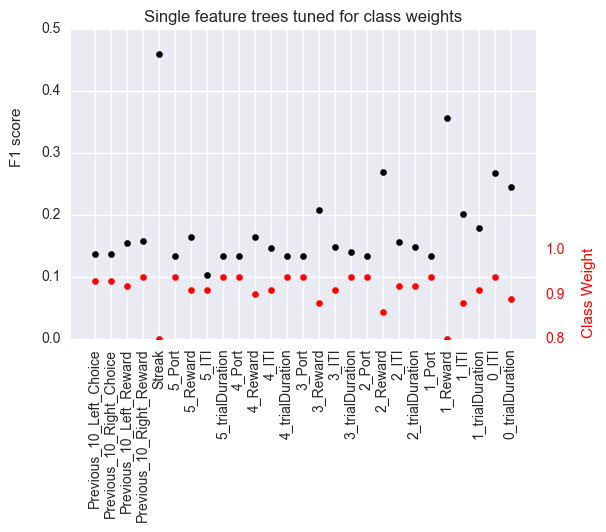

In [58]:
plt.figure(figsize=(10,3))
fig,ax1 = plt.subplots()
ax1.scatter(np.arange(x.shape[1]),F1,color='black')
plt.xticks(np.arange(x.shape[1]),data.columns.values[:-1],rotation = 90)
ax1.set_ylim(0,0.5)
#ax1.set_yticklabels(['','',0.10,0.15,0.20,0.25,0.30])
ax1.set_ylabel('F1 score')
ax1.yaxis.set_label_coords(-0.1,.65)

ax2 = ax1.twinx()
ax2.scatter(np.arange(x.shape[1]),w,color='red')
ax2.set_ylim(0.8,1.5)
ax2.set_yticks([0.8,0.9,1.0])
ax2.set_ylabel('Class Weight',color='r',)
ax2.yaxis.set_label_coords(1.1,0.15)
ax2.grid('off')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.title('Single feature trees tuned for class weights')

Hey look what's making an appearance ... the streak parameter! I wonder if it wasn't being used previously because it's highly correlated with the previous reward and if we use L1 regularization it will just go to zero? Anyway its cool you can see the previous rewards decay, the streak variable, and then everything else is pretty much equal accept for some timing features in the immediate past. 

**Using the class weights determined to be optimal for each feature, train each tree and test on the testing set**

In [40]:
features = data.columns.values[:-1]
F1,acc_pos,acc_neg = [],[],[]
trees = []

for i in range(x.shape[1]):
    tree = Tree.DecisionTreeClassifier(max_depth=1,class_weight={0:(1-w[i]),1:w[i]})
    tree.fit(x_train[:,i].reshape(x_train.shape[0],1),y_train)
    
    y_pred = tree.predict(x_test[:,i].reshape(x_test.shape[0],1))
    ap,an,f = sf.score_both_and_confuse(y_pred,y_test,disp=False,confusion=False)
    F1.append(f)
    acc_pos.append(ap)
    acc_neg.append(an)
    trees.append(tree)

acc_avg = (np.asarray(acc_pos) + np.asarray(acc_neg))/2.0

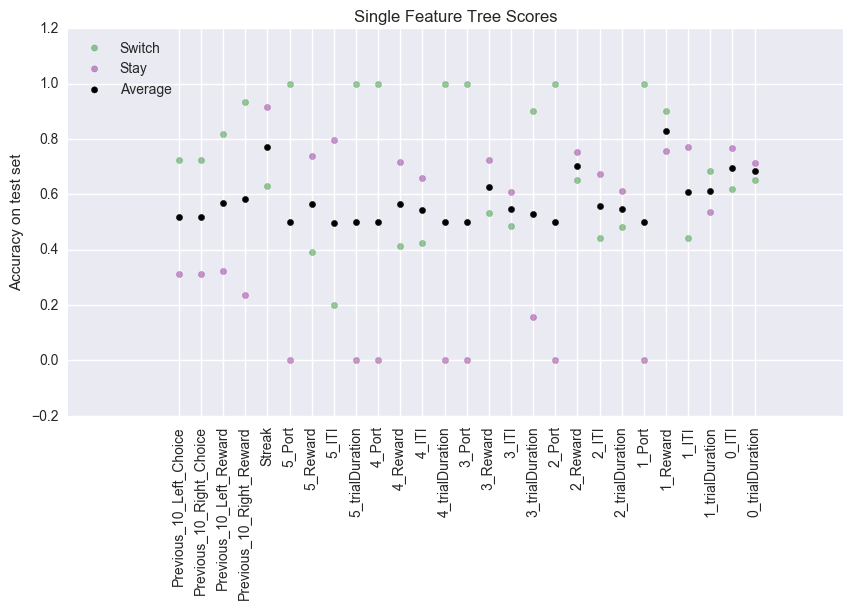

In [41]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(x.shape[1]),acc_pos,color='green',alpha=0.4,label='Switch')
plt.scatter(np.arange(x.shape[1]),acc_neg,color='purple',alpha=0.4,label='Stay')
plt.scatter(np.arange(x.shape[1]),acc_avg,color='black',label = 'Average' )
plt.legend(loc='upper left')
plt.ylabel('Accuracy on test set')
plt.xticks(np.arange(x.shape[1]),data.columns.values[:-1],rotation = 90)
plt.title('Single Feature Tree Scores')

Same general results as with the cross validation

### Try majority vote ensemble

In [42]:
y_prob = np.zeros((x_test.shape[0],len(trees)))

for i in range(x.shape[1]):
    
    y_prob[:,i] = trees[i].predict_proba(x_test[:,i].reshape(x_test.shape[0],1))[:,1]

y_majvote = y_prob[:,[4,10,14,18,22]].mean(axis=1) > 0.5
acc_pos,acc_neg,f1 = sf.score_both_and_confuse(y_majvote,y_test,disp=True,confusion=False)

          Predicted NO  Predicted YES
True NO         2226.0          115.0
True YES          94.0           87.0

F1: 0.454

Accuracy on class 0: 0.95
Accuracy on class 1: 0.48



# Boosting

In [43]:
LR = np.arange(1.5,2.5,0.01)
acc_pos,acc_neg,f1 = [],[],[]

for lr in LR:
    ada = ensemble.AdaBoostClassifier(learning_rate = lr)
    ada.fit(x_train,y_train)
    y_predict = ada.predict(x_test)
    ap,an,f = sf.score_both_and_confuse(y_predict,y_test,disp=False,confusion=False)
    
    acc_pos.append(ap)
    acc_neg.append(an)
    f1.append(f)

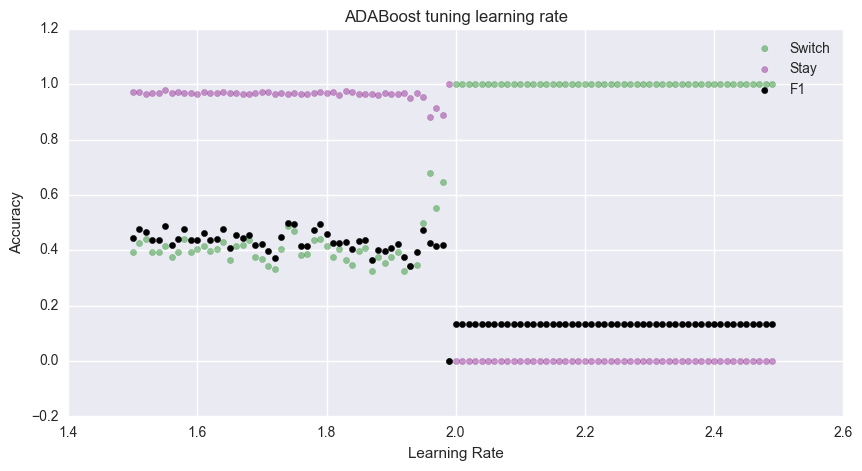

In [44]:
plt.figure(figsize=(10,5))
plt.scatter(LR,acc_pos,color='green',alpha=0.4,label='Switch')
plt.scatter(LR,acc_neg,color='purple',alpha=0.4,label='Stay')
plt.scatter(LR,f1,color='black',label = 'F1' )
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')
plt.title('ADABoost tuning learning rate')

## My own implementation

In [74]:
def fit_predict_boosted_models(x_train,y_train,x_test,models,feature_inds):
    '''
    Fits an ensemble of T decision trees to the training set

    Input:
    x_train: Array of predictors in training set
    y_train: Array of binary responses in training set
    x_test: Array of predictors in training set
    models: list of models to be boosted

    Output:
    model_predict: Array of predicted labels for each test observation
    a: the weights assigned to each model 
    '''

    #helpful variables
    N = x_train.shape[0] #number of observation
    N_test = x_test.shape[0]
    n_features = x_train.shape[1] #number of features
    M = len(models) # number of models to be boosted

    #Step 1: initialize observation weights and other variables:
    w = np.zeros(N) + (1.0/N)
    a,err = np.zeros(M),np.zeros(M) #alpha, residuals
    
    #Step 2: iterate M times
    for m,model in enumerate(models):
        x_train_m = x_train[:,feature_inds[m]].reshape(x_train.shape[0],1)
        x_test_m = x_test[:,feature_inds[m]].reshape(x_test.shape[0],1)
        
        #fit model with weights
        model.fit(x_train_m,y_train,sample_weight=w)
        
        #predict from the model
        y_predict = model.predict(x_train_m)

        #compute error
        err[m] = np.sum(w*(y_predict != y_train)) / np.sum(w)

        #compute alpha
        a[m] = np.log((1-err[m])/err[m])

        #update weights
        w = w*np.exp(a[m]*(y_predict != y_train))

    
    #Step 3 output G(x)
    y_predict,y_weighted = np.zeros((N_test,M)),np.zeros((N_test,M))
    
    for m,model in enumerate(models):
        y_predict[:,m] = model.predict(x_test_m)
        y_predict[y_predict[:,m] == 0,m] = -1

        y_weighted[:,m] = a[m]*y_predict[:,m]
    
    model_predict = np.sign(y_weighted.sum(axis=1))
    
    #convert back to 0s and 1s
    model_predict[model_predict == -1] = 0

    return model_predict,a

In [68]:
boost_features =['Streak','1_Reward','2_Reward','3_Reward','4_Reward','5_Reward']
boost_feature_inds = []
boost_models = []
for f in boost_features:
    boost_models.append(trees[data.columns.get_loc(f)])
    boost_feature_inds.append(data.columns.get_loc(f))
boost_feature_inds = np.asarray(boost_feature_inds)

In [69]:
y_predict,a = fit_predict_boosted_models(x_train,y_train,x_test,boost_models,boost_feature_inds)

In [70]:
acc_pos,acc_neg,f1 = sf.score_both_and_confuse(y_predict,y_test,disp=True,confusion=False)

          Predicted NO  Predicted YES
True NO         2341.0            0.0
True YES         181.0            0.0

F1: 0.000

Accuracy on class 0: 1.00
Accuracy on class 1: 0.00



In [49]:
y_predict,a_all = fit_predict_boosted_models(x_train,y_train,x_test,trees,np.arange(len(trees)))
acc_pos,acc_neg,f1 = sf.score_both_and_confuse(y_predict,y_test,disp=True,confusion=False)

          Predicted NO  Predicted YES
True NO         2341.0            0.0
True YES         181.0            0.0

F1: 0.000

Accuracy on class 0: 1.00
Accuracy on class 1: 0.00



In [50]:
def predict_boosted_models(x_test,models,model_feature_inds,a,proba=False):

    #Step 3 output G(x)
    y_predict,y_weighted = np.zeros((x_test.shape[0],len(models))),np.zeros((x_test.shape[0],len(models)))
    
    for m,model in enumerate(models):
        x_test_m = x_test[:,model_feature_inds[m]].reshape(x_test.shape[0],1)                                                 
        y_predict[:,m] = model.predict(x_test_m)
        y_predict[y_predict[:,m] == 0,m] = -1

        y_weighted[:,m] = a[m]*y_predict[:,m]
    
    model_predict = np.sign(y_weighted.sum(axis=1))
    
    #convert back to 0s and 1s
    model_predict[model_predict == -1] = 0
    
    if proba == False:
        return model_predict
    else:
        return y_weighted.sum(axis=1)

In [71]:
y_proba = predict_boosted_models(x_test,boost_models,boost_feature_inds,a,proba=True)

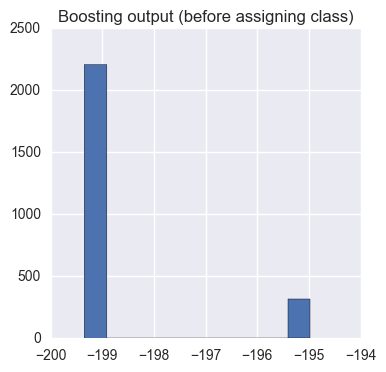

In [72]:
plt.figure(figsize=(4,4))
plt.hist(y_proba)
plt.title('Boosting output (before assigning class)')

In [73]:
y_predict = y_proba > -197
acc_pos,acc_neg,f1 = sf.score_both_and_confuse(y_predict,y_test,disp=True,confusion=False)

          Predicted NO  Predicted YES
True NO         2140.0          201.0
True YES          67.0          114.0

F1: 0.460

Accuracy on class 0: 0.91
Accuracy on class 1: 0.63



In [54]:
y_proba = predict_boosted_models(x_test,trees,np.arange(len(trees)),a_all,proba=True)

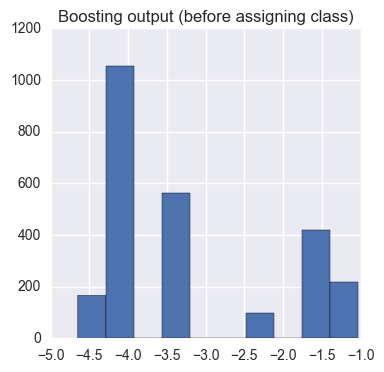

In [55]:
plt.figure(figsize=(4,4))
plt.hist(y_proba,bins=10)
plt.title('Boosting output (before assigning class)')

In [60]:
y_predict = y_proba > -2.0
acc_pos,acc_neg,f1 = sf.score_both_and_confuse(y_predict,y_test,disp=True,confusion=False)

          Predicted NO  Predicted YES
True NO         1838.0          503.0
True YES          45.0          136.0

F1: 0.332

Accuracy on class 0: 0.79
Accuracy on class 1: 0.75

